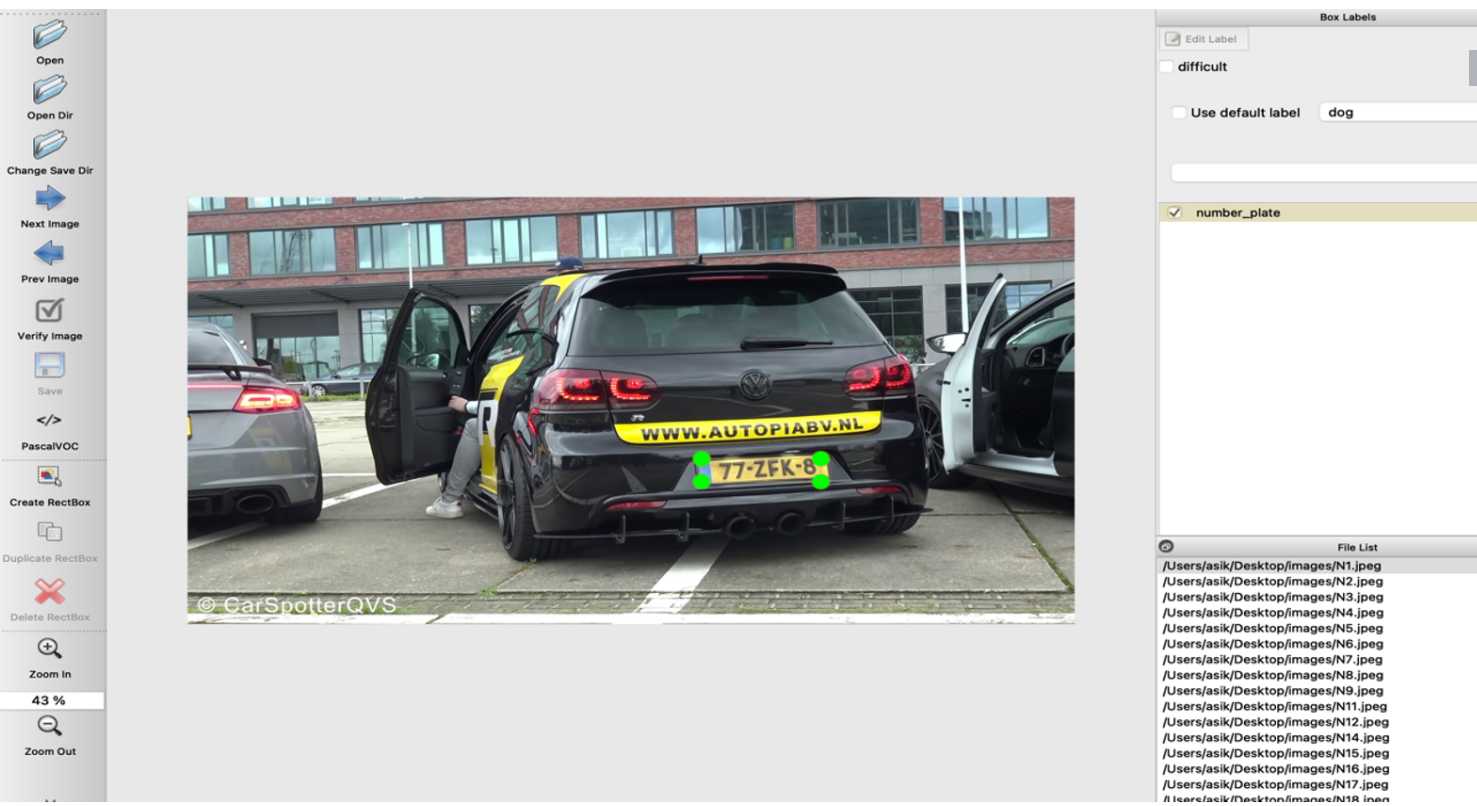

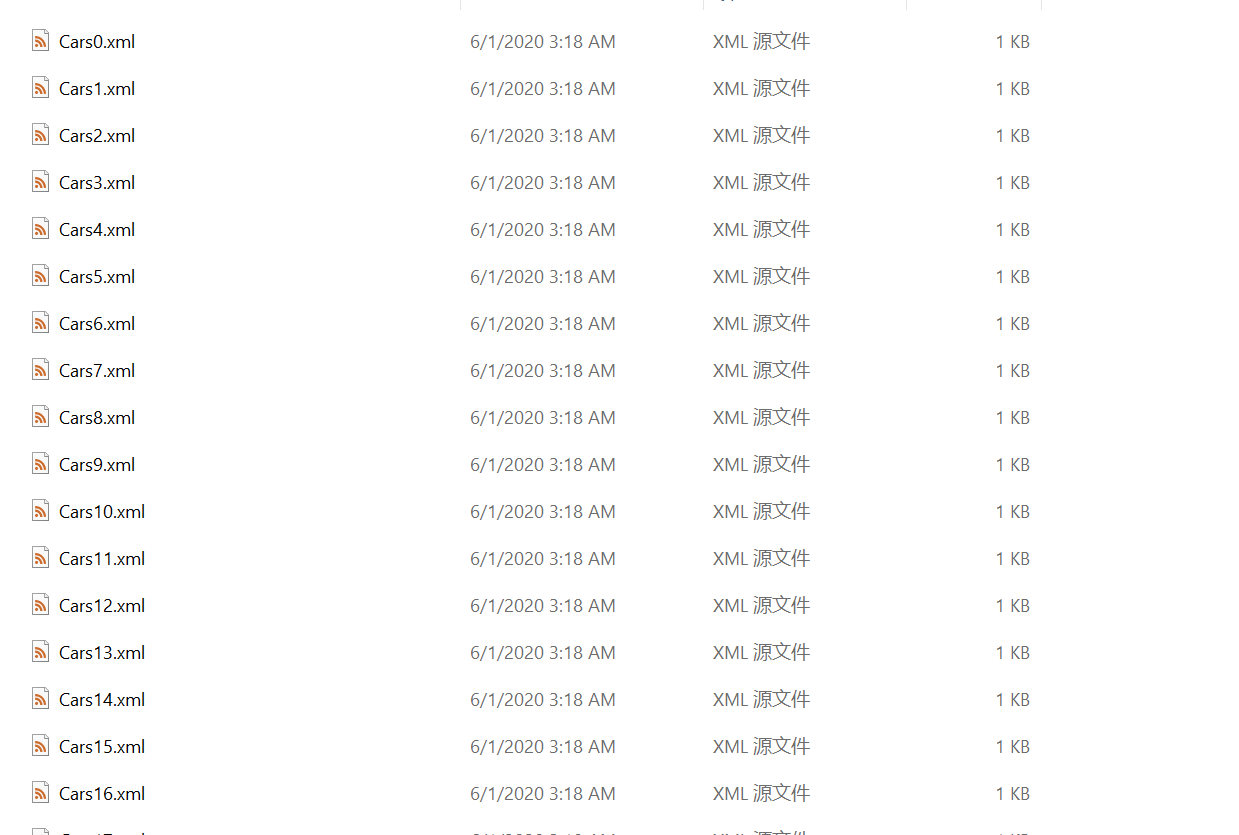


In [ ]:
!git clone https://github.com/ultralytics/yolov5
!pip install -r ./yolov5/requirements.txt

In [ ]:
mkdir /working/yolov5/data_images/
mkdir /working/yolov5/data_images/test/
mkdir /working/yolov5/data_images/train/

In [ ]:
path = glob('../input/number-plate-detection/images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
df = pd.DataFrame(labels_dict)

In [ ]:
df_train = df.iloc[:200]
df_test = df.iloc[200:]

In [ ]:
train_folder = './yolov5/data_images/train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

test_folder = './yolov5/data_images/test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

In [ ]:
!python ./yolov5/train.py --data ../input/number-plate-detection/data.yaml --cfg ./yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 100


In [ ]:
!python ./yolov5/export.py --weight ./yolov5/runs/train/Model/weights/best.pt --include torchscript onnx


In [79]:
import os
import cv2
import numpy as np

import pytesseract as pt
import plotly.express as px
from skimage import io
from skimage.color import rgba2rgb




In [80]:
# settings
INPUT_WIDTH =  640
INPUT_HEIGHT = 640

In [81]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX('best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [85]:
def get_detections(img,net):
    # 1.CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = img

    # 2. GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    # print(detections)
    
    return input_image, detections

def non_maximum_supression(input_image,detections):
    
    # 3. FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
    
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        # print(confidence)
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            # print(class_score)
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]
                # print(cx)
                # print('\n')
                # print(cy)
                # print('\n')
                # print(w)
                # print('\n')
                # print(h)
                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])
                # print(box)
                confidences.append(confidence)
                boxes.append(box)
    # print(boxes)
    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    
    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)
    
    return boxes_np, confidences_np, index
# extrating text
def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    
    if 0 in roi.shape:
        return 'no number'
    
    else:
        text = pt.image_to_string(roi)
        text = text.strip()
        
        return text
def drawings(image,boxes_np,confidences_np,index):
    # 5. Drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return image

In [83]:
# predictions flow with return result
def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # print(boxes_np)
    # step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img

In [86]:
# test
path=r'C:\Users\m0815\Downloads\Automatic-License-Plate-Detection-main\images'
pics=[path+'/N'+str(i)+'.jpeg' for i in range(50,80)]
for i in pics:
    img = io.imread(i)
    results = yolo_predictions(img,net)
    fig = px.imshow(img)
    fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
    fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
    fig.show()

FileNotFoundError: No such file: 'C:\Users\m0815\Downloads\Automatic-License-Plate-Detection-main\images\N55.jpeg'

In [ ]:
cap = cv2.VideoCapture('../input/number-plate-detection/TEST/TEST.mp4')
while True:
    ret, frame = cap.read()
    
    if ret == False:
        print('Unable to read video')
        break
        
    results = yolo_predictions(frame,net)
    
    cv2.namedWindow('YOLO',cv2.WINDOW_KEEPRATIO)
    cv2.imshow('YOLO',results)
    if cv2.waitKey(30) == 27 :
        break
        
cv2.destroyAllWindows()
cap.release()